This notebook attemps to solve the regression problem with housing data using the code templates developed for spark.
Version 1

In [253]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Imports

###### Global Imports

In [153]:
import pandas as pd
import numpy as np
import sys
sys.path.append(r"D:\tigerml_new\code-templates\scripts\spark")

In [271]:
!pip install pyspark-dist-explore
!pip install hvplot

In [254]:
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql import types as DT
from pyspark.sql import functions as F

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoderEstimator, Imputer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from IPython.display import display,display_html

from cytoolz.functoolz import compose

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

import holoviews as hv
import hvplot

import panel as pn
pn.extension('bokeh')

import dp
import features
import model_gen
import model_eval
import utils
import eda

#### DATA READ

In [186]:
%%time
data = dp.read_data(spark=spark, path="/FileStore/tables/housing/housing.csv", fs="dbfs", fmt="csv", header="true", inferschema="true")
data.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

Wall time: 1.15 s


#### Identification of columns types in the data

In [156]:
%%time
num_cols = dp._list_numerical_columns( data)
cat_cols = dp._list_categorical_columns( data)   
bool_cols = dp._list_boolean_columns( data)
date_cols = dp._list_datelike_columns( data)
num_cols, cat_cols, bool_cols, date_cols

Wall time: 998 µs


(['longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'population',
  'households',
  'median_income',
  'median_house_value'],
 ['ocean_proximity'],
 [],
 [])

## EDA

## Health Analysis
This tells about
1. percentage of Numeric variables and other variables
2. %age of missing values
3. %age of duplicated rows

In [157]:
health_plot=eda.plot_health(data)

In [158]:
pn.panel(health_plot)

HoloViews(Layout)

### Missing Plot
This plot is the relation between no of non missing variables with no of missing observations

In [159]:
missing_value_plot=eda.missing_plot(data)

In [160]:
pn.panel(missing_value_plot)

HoloViews(Bars)

### Missing data summary


In [161]:
missing_summary=eda.missing_value_summary(data)

In [162]:
pn.panel(missing_summary)

DataFrame(DataFrame)

### Outliers summary

In [163]:
outliers_summary=eda.get_outliers_table(data)

In [164]:
pn.panel(outliers_summary,width=600)

DataFrame(DataFrame, width=600)

## Feature Analysis

In [165]:
numerical_analysis,categorical_analysis=eda.feature_analysis_table(data)

#### descriptive analysis of numerical columns

In [166]:
pn.panel(numerical_analysis,width=1500)

DataFrame(DataFrame, width=1500)

#### descriptive statics of categorical variables

In [167]:
pn.panel(categorical_analysis,width=600)

DataFrame(DataFrame, width=600)

### Distributions of numerical and categorical variables

In [168]:
numerical_dict,categorical_dict=eda.feature_density_plots(data)

#### To Fix: To plot all the variables in grid

In [169]:
pn.panel(numerical_dict[num_cols[0]])

HoloViews(Layout)

In [170]:
pn.panel(categorical_dict[cat_cols[0]])

HoloViews(Layout)

## Feature Interations

### correlation table

In [171]:
table=eda.get_feature_interactions(data,plot='table')

In [174]:
pn.panel(table, width=700)

DataFrame(DataFrame, width=700)

### correlation plot

In [175]:
correlation_plot=eda.get_feature_interactions(data,plot='plot')

In [176]:
pn.panel(correlation_plot)

HoloViews(HeatMap)

## Key Drivers

### correlations with target variabls

In [177]:
target_var='median_house_value'
correlation_table=eda.correlation_with_target(data,target_var)

In [178]:
pn.panel(correlation_table)

HoloViews(Bars)

### Feature Importance based on Random Forests

In [179]:
plot=eda.feature_importance(data,target_var,False)


In [180]:
pn.panel(plot)

HoloViews(Bars)

### cleaning string columns
    converting the strings to lower case

## pipeline to clean the data
1. cleaning the column names
2. cleaning the string columns
3. split train test

In [187]:
pipeline= compose(
    _clean_columns(),# column cleaning
    _clean_string_val(cols=['ocean_proximity'],lower=True), # clean string columns
    )
clean_data=pipeline(data)

### train test split

In [188]:
train,test=test_train_split(clean_data,train_prop= 0.8, random_seed=42) # test train split

#### Identification and Handling of Missing Values

In [183]:
print(train.count())
dp.identify_missing_values(train).show()

16549
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           163|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [184]:
print(test.count())
dp.identify_missing_values( test).show()

4091
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|            44|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



Only 1 column(total_bedrooms) with missing data. Handling them by imputing through mean.
 
 Other functionalities of missing values can be observed in dp module

## Impute Missing data

In [92]:
from pyspark.ml import Pipeline, Transformer
from pyspark.sql import DataFrame
from pyspark.ml import Estimator
class Imputer(Estimator,Transformer):
    """
    A custom Transformer imputes missing values
    """
    def __init__(self, cols=[], rules={}):
        super().__init__()
        self.cols = cols
        self.rules = rules
        
    def _fit(self,df:DataFrame):
        self.impute_dict=dp.handle_missing_values(df,self.cols,self.rules)
        return self
        

    def _transform(self, df: DataFrame) -> DataFrame:
        df=dp._impute_missing_val(df,self.impute_dict)
        return df


In [93]:
# imputer = Imputer()
# model = Pipeline(stages=[imputer]).fit(train)
# train_transformed = model.transform(train)
# test_transformed = model.transform(test)

In [95]:
# imputer.fit(train)

In [7]:
imputer = dp.Imputer()
imputer.fit(train)
model = Pipeline(stages=[imputer]).fit(train)
train_transformed = model.transform(train)
test_transformed = model.transform(test)

#### checking the imputed dataframe

In [191]:
dp.identify_missing_values(test_transformed).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



## Outlier treatment

In the above function if drop=False and cap=True is input, instead of dropping the rows, the outliers will be capped to the relevant bounds.

More on this in features module

In [234]:
outlier=dp.Outlier_Treatment(cols=[], drop=True, cap=False, method='iqr', iqr_multiplier=1.5)
outlier.fit(train_transformed)
train_out_transformed=outlier.transform(train_transformed)

{'longitude': {'q1': -121.81, 'q3': -118.0, 'min_b': -127.525, 'max_b': -112.285}, 'latitude': {'q1': 33.93, 'q3': 37.71, 'min_b': 28.259999999999998, 'max_b': 43.38}, 'housing_median_age': {'q1': 18.0, 'q3': 37.0, 'min_b': -10.5, 'max_b': 65.5}, 'total_rooms': {'q1': 1446.0, 'q3': 3143.0, 'min_b': -1099.5, 'max_b': 5688.5}, 'total_bedrooms': {'q1': 297.0, 'q3': 642.0, 'min_b': -220.5, 'max_b': 1159.5}, 'population': {'q1': 785.0, 'q3': 1724.0, 'min_b': -623.5, 'max_b': 3132.5}, 'households': {'q1': 279.0, 'q3': 603.0, 'min_b': -207.0, 'max_b': 1089.0}, 'median_income': {'q1': 2.5664, 'q3': 4.7426, 'min_b': -0.6979000000000011, 'max_b': 8.006900000000002}, 'median_house_value': {'q1': 119600.0, 'q3': 264900.0, 'min_b': -98350.0, 'max_b': 482850.0}}


## Binning of Data

In [236]:
bin_=features.Binner(cols=['population'],rules={'population':{'n':10}})
bin_.fit(data)
train_binned_df=bin_.transform(train_out_transformed)
test_binned_df=bin_.transform(test_transformed)

## Encoding categorical data

In [237]:
encoder=features.Encoder(cols=['ocean_proximity'],rules={'ocean_proximity':{'method':'target','target_col':'median_house_value'}})
encoder.fit(train_binned_df)
model = Pipeline(stages=[encoder]).fit(train_binned_df)
train_transformed_enc = model.transform(train_binned_df)
test_transformed_enc = model.transform(test_binned_df)

ocean_proximity {'method': 'target', 'target_col': 'median_house_value'}
{'col_name': 'ocean_proximity', 'mapper': {'island': 371875.0, 'near bay': 227233.7908496732, 'inland': 118594.09065699659, 'near ocean': 220821.23401889938, '1h ocean': 219246.83127572018}, 'prefix': 'target_mean_encoded'}


#### Model DataPrep and Vector Generation

In [239]:
%%time
target_col = 'median_house_value'
outlier_indicators = [x for x in train_transformed_enc.columns if 'outlier' in x]
index_columns = [x for x in train_transformed_enc.columns if 'index' in x]
num_cols_1 = dp._list_numerical_columns( train_transformed_enc)
cat_cols_1 = dp._list_categorical_columns( train_transformed_enc)   
bool_cols_1 = dp._list_boolean_columns( train_transformed_enc)
date_cols_1 = dp._list_datelike_columns( train_transformed_enc)
num_cols_1, cat_cols_1, bool_cols_1, date_cols_1

Wall time: 998 µs


(['longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'population',
  'households',
  'median_income',
  'median_house_value',
  'bucketed_population',
  'target_mean_encodedocean_proximity'],
 ['ocean_proximity'],
 [],
 [])

In [246]:
## bucketed columns
feature_cols = num_cols_1
bucketed_feat=['_'.join(i.split('_')[1:]) for i in feature_cols if i.split('_')[0]=='bucketed']
feature_cols.remove(target_col)
feature_cols=list(set(feature_cols)-set(bucketed_feat))
# feature_cols = [x for x in feature_cols if x not in index_columns]
# feature_cols = [x for x in feature_cols if x not in outlier_indicators]
# feature_cols = [x for x in feature_cols if x not in cat_cols_1]
# feature_cols = [x for x in feature_cols if x not in date_cols_1]
feature_cols

['total_rooms',
 'total_bedrooms',
 'longitude',
 'households',
 'target_mean_encodedocean_proximity',
 'latitude',
 'housing_median_age',
 'bucketed_population',
 'median_income']

In [248]:
%%time
model_data_train = dp.generate_features_vector(spark, train_transformed_enc, feature_cols, output_col="features")
model_data_test = dp.generate_features_vector(spark, test_transformed_enc, feature_cols, output_col="features")

Wall time: 383 ms


In [259]:
model_data_test.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'bucketed_population',
 'target_mean_encodedocean_proximity',
 'features']

#### Train Test Split(not relevant anymore)

In [15]:
%%time
train_df, test_df = dp.test_train_split(spark, data=model_data, features_col="features", target_col=target_col, train_prop=0.7, random_seed=111)

Wall time: 268 ms


#### Model Train and Eval

In [256]:
model_gen.valid_model_types

['regression', 'classification']

In [255]:
model_gen.model_objects

{'regression': {'aft_survival': {'estimator': 'pyspark.ml.regression.AFTSurvivalRegression',
   'model': 'pyspark.ml.regression.AFTSurvivalRegressionModel'},
  'decision_tree': {'estimator': 'pyspark.ml.regression.DecisionTreeRegressor',
   'model': 'pyspark.ml.regression.DecisionTreeRegressionModel'},
  'gbt': {'estimator': 'pyspark.ml.regression.GBTRegressor',
   'model': 'pyspark.ml.regression.GBTRegressorModel'},
  'glm': {'estimator': 'pyspark.ml.regression.GeneralizedLinearRegression',
   'model': 'pyspark.ml.regression.GeneralizedLinearRegressionModel'},
  'isotonic_regression': {'estimator': 'pyspark.ml.regression.IsotonicRegression',
   'model': 'pyspark.ml.regression.IsotonicRegressionModel'},
  'linear_regression': {'estimator': 'pyspark.ml.regression.LinearRegression',
   'model': 'pyspark.ml.regression.LinearRegressionModel'},
  'rf': {'estimator': 'pyspark.ml.regression.RandomForestRegressor',
   'model': 'pyspark.ml.regression.RandomForestRegressorModel'}},
 'classificat

In [257]:
%%time
_model_str_ = 'linear_regression'
estimator = utils.load_class(model_gen.model_objects['regression'][_model_str_]['estimator'])
estimator

Wall time: 16.1 ms


pyspark.ml.regression.LinearRegression

In [19]:
%%time
_model_ = estimator(featuresCol="features", labelCol="y", predictionCol='yhat')
model = _model_.fit(train_df)
preds = model.transform(test_df)
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))
preds.select("y","yhat").show(5)

Coefficients: [-24817.46651340653,-23300.002454764835,853.0072337762257,-13.416567756857596,138.55314214359697,-60.00021814943204,113.41049495976932,39166.81542637564,-157872.81248472678,-194161.38518153332,-159218.22851135483,-168755.21967581604]
Intercept: -1951633.858758544
+-------+------------------+
|      y|              yhat|
+-------+------------------+
|76100.0|171576.20768365124|
|78300.0|129096.53608194599|
|58100.0| 136995.0602644598|
|66900.0|114746.66764388373|
|90100.0|184371.28858566703|
+-------+------------------+
only showing top 5 rows

Wall time: 22.5 s


#### Model Evaluation Metrics

In [20]:
%%time
reg_metrics = model_eval.get_regression_metrics(spark, data=preds, y_col='y' , y_pred_cols=['yhat'])
reg_metrics.show()

C:\Users\saikrishna.kallu\Anaconda3\envs\tigerml-env\envs\spark_template_env\lib\site-packages\pyspark\sql\session.py:776: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


+------------------+-------------------+
|            metric|               yhat|
+------------------+-------------------+
|Explained Variance|0.37365392070634923|
|              RMSE|  57715.54470293234|
|               MAE| 42770.326835381464|
|               MSE|3.331084100356181E9|
|              MAPE|0.26972165972890816|
|             WMAPE| 0.2289457997349431|
|              R.Sq| 0.6262650820027573|
+------------------+-------------------+

Wall time: 23.1 s


#### Regression Plots

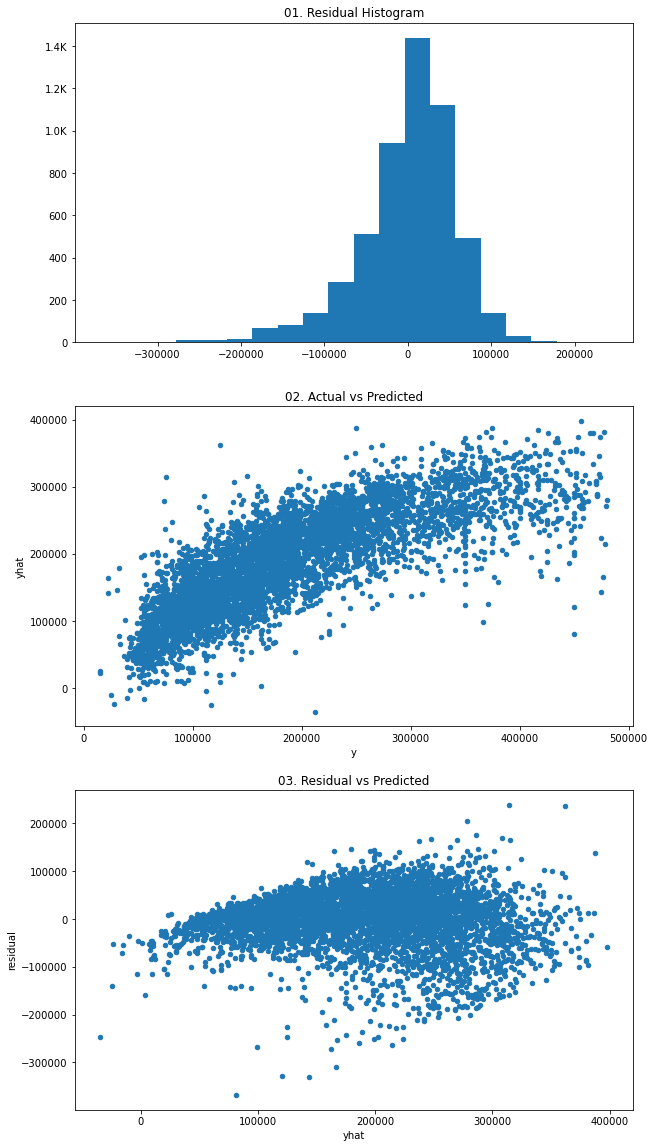

Wall time: 13.1 s


In [27]:
%%time
model_eval.generate_regression_plots(spark, preds, 'y', 'yhat')